# Landau matching using curraun and exporting to MUSIC

In this notebook we compute the energy momentum tensor of the Glasma at a particular switching time $\tau_s$, diagonalize it and compute the local rest frame energy density and the local four velocity of the Glasma. These quantities can be used in initial conditions for a hydrodynamic simulation like MUSIC.

In [45]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.kappa as kappa
import curraun.qhat as qhat
from curraun.energy import Energy
import curraun.initial as initial
initial.DEBUG = False
from curraun.tmunu import EnergyMomentumTensor, convert_to_matrix, landau

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle, datetime
from tqdm import tqdm

import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size':16})

fig_x, fig_y = 9, 9

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

The following function takes a dictionary of parameters `p` as input and simulates the Glasma until $\tau$ reaches the switching time $\tau_s$. The function then returns the parameter dictionary `p` and the simulation object `s`.

In [2]:
def simulate(p):    
    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    p['E0'] = E0
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']

    print("Initializating ...")
        
    with tqdm(total=maxt, file=sys.stdout) as pbar:

        s = core.Simulation(p['N'], DT, p['G'])
        va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'], shape_func = p['SHAPE_A'])
        vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'], shape_func = p['SHAPE_B'])
        initial.init(s, va, vb)

        if use_cuda:
            s.copy_to_device()
            meminfo = cuda.current_context().get_memory_info()

        for t in range(maxt):
            core.evolve_leapfrog(s)

            pbar.set_description('Simulating... | {:.2f} GB / {:.2f} GB'.format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))
            pbar.update(1)
    
        s.copy_to_host()

        if use_cuda:
            cuda.current_context().deallocations.clear()
            
    print("Simulation complete!")
    return p, s

# Simulating the Glasma

Next we simulate an off-central collision of two large nuclei. We define a shape function for each nucleus based on the Woods-Saxon distribution with two parameters: $R_0$ and $a$:
$$ s(r) = \frac{1}{1 + \exp \big((r - R_0) / a\big)}$$

We take the values for these parameters from table 4.1 of **arXiv:1712.05815**

$$R_0 = 6.38 \, \mathrm{fm}$$

$$a = 0.535 \, \mathrm{fm}$$

This shape function is used to modulate the color charge density $\rho(x)$ of the MV model.

$$ \rho(x) \rightarrow s(r) \rho(x)$$

At the center of the nucleus we have $s(r \ll R_0) \approx 1$ and thus the variance of the color charges will be $g^2 \mu^2$ as in the original MV model. Outside the nucleus $r \gg R_0$ the charge density is approximately zero. A non-zero impact parameter $b$ for off-central collisions can be added by shifting the radius $r$ by either $+b/2$ or $-b/2$.

The MV model parameters are chosen in a way to fix the value of $Q_s$ as detailed in **arXiv:0711.3039**. For $N_s = 50$ color sheets per nucleus we have $Q_s \approx 0.95 g^2 \mu$ for $m = 0.1 g^2 \mu$. The Yang-Mills coupling constant $g$ is set to $g = 2$.

The Glasma is simulated up to the switching time $\tau_s = 0.4 \, \mathrm{fm}/c$.




In [22]:
# Nuclear geometry
R0 = 6.38                    # nuclear radius [fm]
a = 0.535                    # nuclear thickness [fm]
b = 5.0                      # impact parameter [fm]

# MV model parameters
Qs = 1.5                     # saturation momentum [GeV]
g = 2.0
mu = Qs / (0.95 * g ** 2)    # MV model parameter [GeV]
m = 0.1 * g ** 2 * mu        # infrared regulator [GeV]
tau_s = 0.4                  # switching time [fm/c]

# Standard MV model paramaters
p = {
    # Parameters for simulation box
    'L':    30.0,           # transverse size [fm]
    'N':    512,            # lattice size
    'DTS':  64,             # time steps per transverse spacing
    'TMAX': tau_s,          # max. proper time (tau) [fm/c]

    # Parameters for MV model
    'G':    2.0,            # YM coupling constant
    'MU':   mu,             # MV model parameter [GeV]
    'M':    m,              # IR regulator [GeV]
    'UV':   1000000.0,      # UV regulator [GeV]
    'NS':   50,             # number of color sheets
    
    # Paramaters for nuclear geometry
    'R':    R0,             # nuclear radius [fm]
    'A':    a,              # width of the nuclear boundary [fm]
    'B':    b,              # impact parameter [fm]
}

# This defines a simple shape funtion for each nucleus.
def woods_saxon(x, y, bx, by, R, a, aT):
    r = np.sqrt((x * aT - bx/2) ** 2 + (y * aT - by/2) ** 2)
    return 1.0 / (1.0 + np.exp((r-R) / a))

# Add the shape functions
def shape_A(x, y):
    return woods_saxon(x, y, +p['B'], 0.0, p['R'], p['A'], p['L'] / p['N'])

def shape_B(x, y):
    return woods_saxon(x, y, -p['B'], 0.0, p['R'], p['A'], p['L'] / p['N'])

p['SHAPE_A'] = shape_A
p['SHAPE_B'] = shape_B

Before starting the simulation we visualize the collision geometry. The impact parameter for this collision is non-zero.

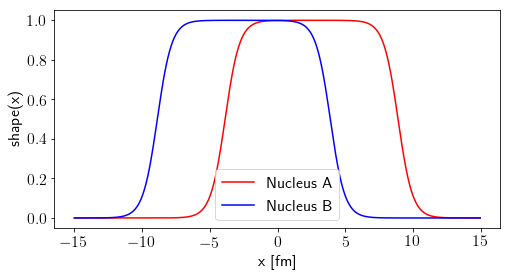

In [35]:
X = np.arange(-p['N'] // 2, p['N'] // 2)
plt.plot(X * p['L'] / p['N'], [shape_A(x, 0) for x in X], 'r', label='Nucleus A')
plt.plot(X * p['L'] / p['N'], [shape_B(x, 0) for x in X], 'b', label='Nucleus B')
plt.xlabel("x [fm]")
plt.ylabel("shape(x)")
plt.legend()
plt.gcf().set_size_inches(fig_x, fig_y/2)
plt.show()

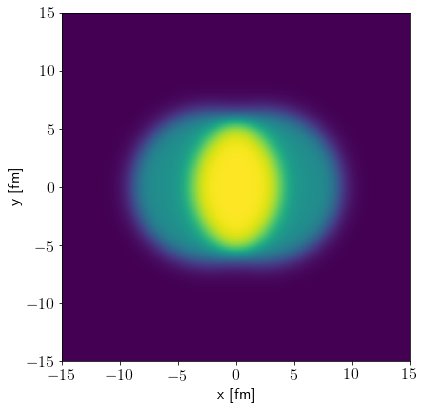

In [36]:
X = np.arange(-p['N'] // 2, p['N'] // 2)
Y = np.arange(-p['N'] // 2, p['N'] // 2)

shape_array = [[p['SHAPE_A'](x, y) + p['SHAPE_B'](x, y)  for x in X] for y in Y]

plt.imshow(shape_array, extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2], origin="lower")
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
plt.gcf().set_size_inches(fig_x * 0.8 , fig_y * 0.8)
plt.show()

Now we simulate the event up to the matching proper time $\tau_s$. The initialization routine can take a while.

In [26]:
p, s = simulate(p)

Initializating ...
Simulating... | 7.57 GB / 11.78 GB: 100%|██████████| 384/384 [00:16<00:00, 23.34it/s]  
Simulation complete!


# Landau matching

Next, we perform the Landau matching procedure.

The following function computes the energy momentum tensor, diagonalizes it and returns a 2D array of the local rest frame (LRF) energy density $\varepsilon$ and arrays for $u^\tau$, $u^x$, $u^y$. It also returns the original energy-momentum tensor $T_{\mu\nu}$. The longitudinal flow $u^\eta$ is traditionally set to zero (see e.g. Scott McDonald's master thesis and **arXiv:1704.07680**), which is accomplished by just diagonalizing the $3 \times 3$ submatrix of $T^{\mu\nu}$ (i.e. by ignoring all $\eta$ components). This reduction can be turned off by setting `use_reduced_T=False`, but this more of an experimental feature.

The initial data used in hydrodynamical simulations typically do not use the same high resolution needed in Yang-Mills simulations. Therefore one can downsample the data before computing the LRF energy and $u^\mu$ by setting `downsample_step` to some integer higher than 1.

Landau matching is performed by solving $T^\mu_{\,\,\nu} u^\nu = \varepsilon u^\mu$ at every point in the transverse plane. This is equivalent to solving the eigenvalue problem and picking the time-like vector $u_\mu u^\mu = 1$. Sometimes this procedure fails in certain lattice cells due to numerical issues. For example, sometimes (but rarely!) the method does not find a time-like vector $u^\mu$. In that case the cell is treated as if it has no flow velocity. In other cases, the LRF energy density does not turn out to be positive. If this happens, the cell is again treated as if there was no flow. This should happen only in rare cases (especially for the reduced $T_{\mu\nu}$ method). If such issues arise, information about it will be printed to the terminal.

The `landau` function takes the simulation object `s` and the energy scale $E_0$ as input. The energy scale $E_0$ is simply the inverse lattice spacing $a_T^{-1}$ given in units of GeV. The `compute` function puts this value into the parameter dictionary `p`.

In [60]:
eps, u, T = landau(s, p['E0'], downsample_step=2, use_reduced_T=True)

We plot the results of the Landau matching procedure. We start with the LRF energy density $\varepsilon$ and compare it (visually) to the energy density of the Milne frame $T^{\tau\tau}$.

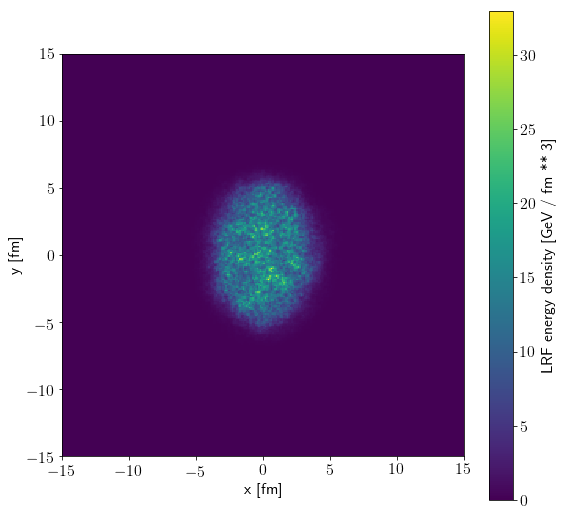

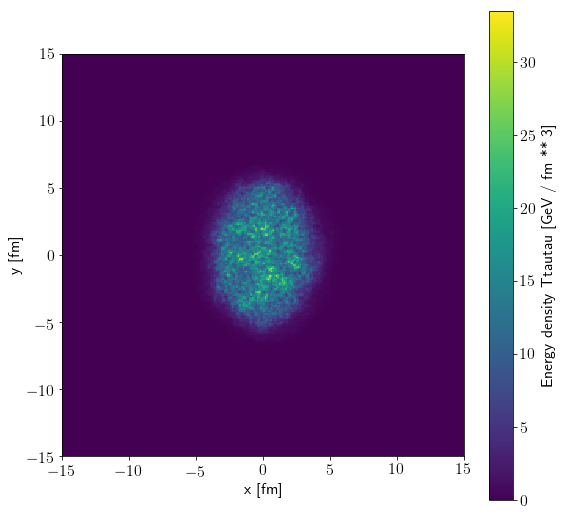

In [61]:
plt.imshow(eps.T, extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2], origin="lower")
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
cbar = plt.colorbar()
cbar.set_label("LRF energy density [GeV / fm ** 3]")
plt.gcf().set_size_inches(fig_x, fig_y)
plt.show()

plt.imshow(T[:, :, 0, 0].T, extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2], origin="lower")
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
cbar = plt.colorbar()
cbar.set_label("Energy density Ttautau [GeV / fm ** 3]")
plt.gcf().set_size_inches(fig_x, fig_y)
plt.show()

A neat way to visualize the flow velocities $u^x$ and $u^y$ is to define the energy density weighted flow

$$ w^x(r) = \epsilon(r) u^x(r) / \left< \epsilon \right>$$

$$ w^y(r) = \epsilon(r) u^y(r) / \left< \epsilon \right>$$

and superimpose it over the LRF energy density. This is similar to what Scott did in his master thesis.

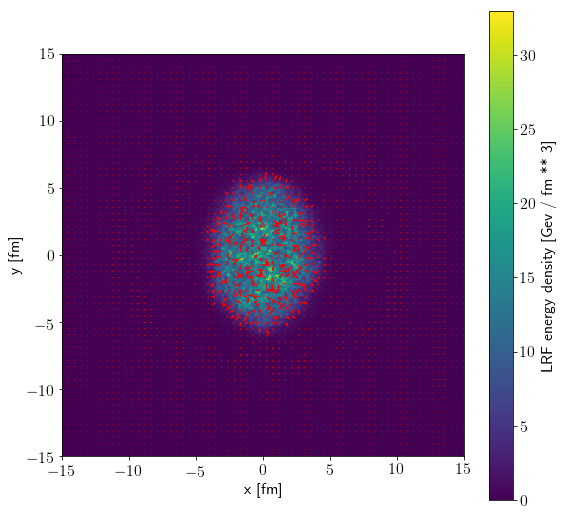

In [94]:
step = 4
n = u.shape[0]

X = np.linspace(-p['L']/2, p['L']/2, num=n // step)
Y = np.linspace(-p['L']/2, p['L']/2, num=n // step)

epsd = np.zeros((n // step, n // step))
udx = np.zeros((n // step, n // step))
udy = np.zeros((n // step, n // step))

for x in range(n // step):
    for y in range(n // step):
        reduced_ux = u[step*x:step*(x+1), step*y:step*(y+1), 1]
        reduced_uy = u[step*x:step*(x+1), step*y:step*(y+1), 2]
        reduced_eps = eps[step*x:step*(x+1), step*y:step*(y+1)]
        udx[x, y] = np.mean(np.mean(reduced_ux, axis=0), axis=0)
        udy[x, y] = np.mean(np.mean(reduced_uy, axis=0), axis=0)
        epsd[x, y] = np.mean(np.mean(reduced_eps, axis=0), axis=0)
        
wx = udx * epsd / np.mean(epsd)
wy = udy * epsd / np.mean(epsd)

plt.imshow(eps.T, origin="lower", extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2])
cbar = plt.colorbar()
cbar.set_label("LRF energy density [Gev / fm ** 3]")
plt.quiver(X, Y, wdx.T, wdy.T, scale=80, color='r', angles='xy')
plt.gca().set_aspect(1)
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
plt.gcf().set_size_inches(fig_x, fig_y)

We can also inspect the components of the energy momentum tensor `T`. This is done in the next few figures. We start with the energy flux $S_x$ and $S_y$.

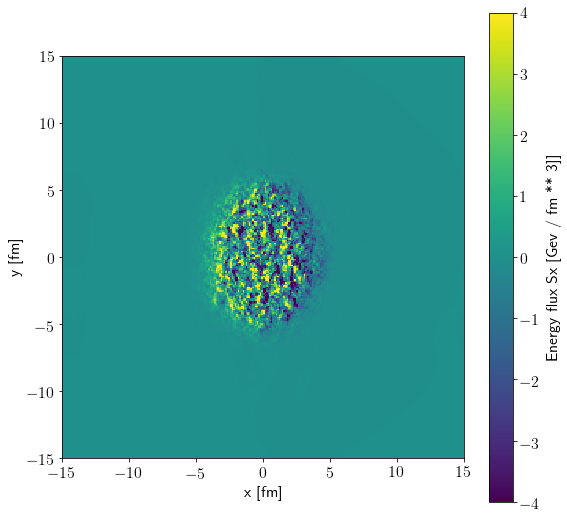

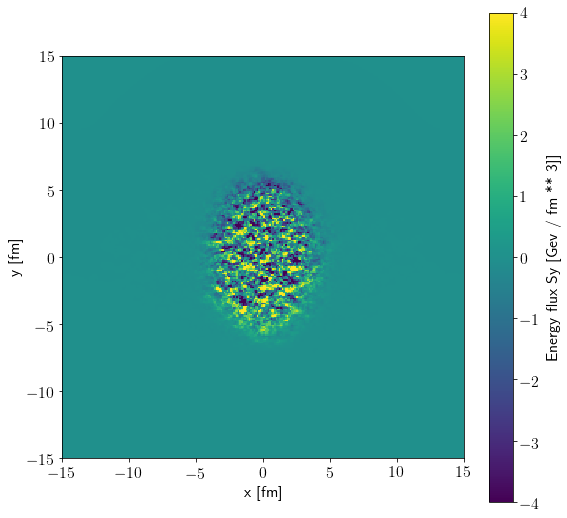

In [95]:
f = 4

plt.imshow(T[:, :, 0, 1].T, vmin=-f, vmax=f, origin="lower", extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2])
cbar = plt.colorbar()
cbar.set_label("Energy flux Sx [Gev / fm  ** 3]]")
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
plt.gcf().set_size_inches(fig_x, fig_y)
plt.show()

plt.imshow(T[:, :, 0, 2].T, vmin=-f, vmax=f, origin="lower", extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2])
cbar = plt.colorbar()
cbar.set_label("Energy flux Sy [Gev / fm  ** 3]]")
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
plt.gcf().set_size_inches(fig_x, fig_y)
plt.show()

We also plot the shear stress and the transverse pressures.

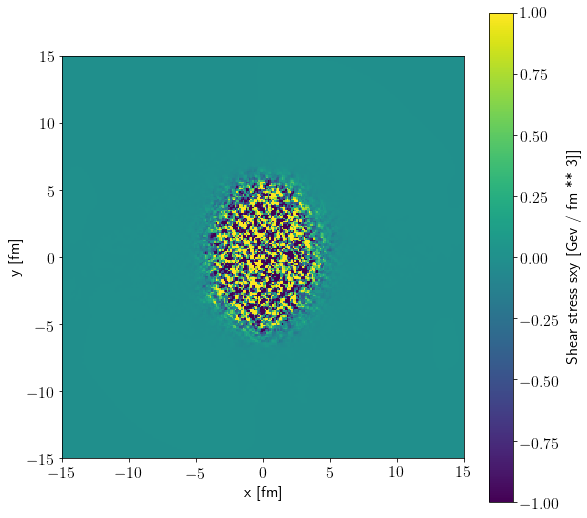

In [96]:
f = 1

plt.imshow(T[:, :, 1, 2].T, vmin=-f, vmax=f, origin="lower", extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2])
cbar = plt.colorbar()
cbar.set_label("Shear stress sxy [Gev / fm  ** 3]]")
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
plt.gcf().set_size_inches(fig_x, fig_y)
plt.show()

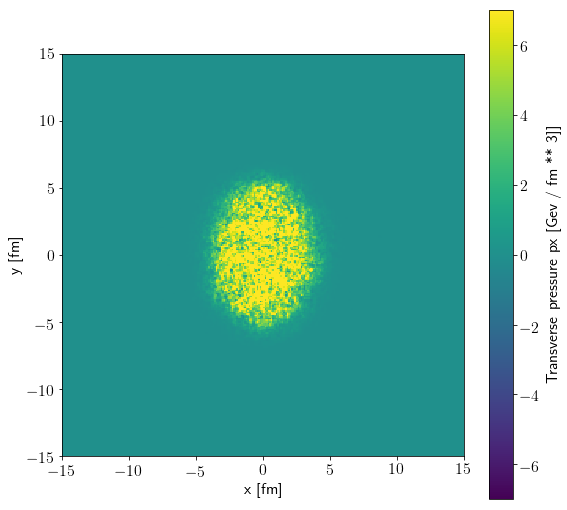

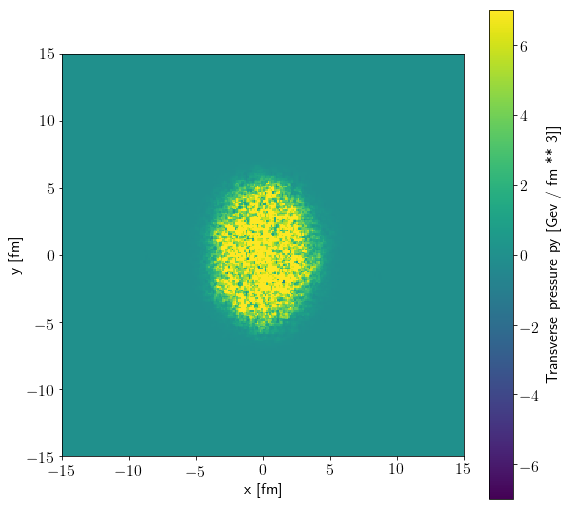

In [97]:
f = 7

plt.imshow(T[:, :, 1, 1].T, vmin=-f, vmax=f, origin="lower", extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2])
cbar = plt.colorbar()
cbar.set_label("Transverse pressure px [Gev / fm  ** 3]]")
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
plt.gcf().set_size_inches(fig_x, fig_y)
plt.show()

plt.imshow(T[:, :, 2, 2].T, vmin=-f, vmax=f, origin="lower", extent=[-p['L']/2, +p['L']/2, -p['L']/2, +p['L']/2])
cbar = plt.colorbar()
cbar.set_label("Transverse pressure py  [Gev / fm  ** 3]]")
plt.xlabel("x [fm]")
plt.ylabel("y [fm]")
plt.gcf().set_size_inches(fig_x, fig_y)
plt.show()

# Exporting for MUSIC

As a last step, we want to save the energy density and the flow velocity to an external file. The input format is described here: 

https://webhome.phy.duke.edu/~jp401/music_manual/initial.html

In particular, we follow the same format as IP-Glasma:

https://quark.phy.bnl.gov/~bschenke/ipglasma-doc.txt




```
The structure of these files is

Row 1:
\# dummy 1 etamax = ETAMAX xmax = XMAX ymax= YMAX deta= 0 dx= DX dy=DY

All other rows:

{eta} {x} {y} {energy density [GeV/fm^3]} {u^tau} {u^x} {u^y} {T^00} {T^0x} {T^0y} {T^0eta}

All you need (or the only things that should be in the file) is column 4: energy density, column 6: u^x and column 7: u^y

Everything else is irrelevant.
```

In [111]:
# specify output file
out_file = "music_ic.dat"

# header
aT = hbarc / p['E0']
xmax = eps.shape[0]
ymax = eps.shape[1]
header = "dummy 1 etamax= 1 xmax= {} ymax= {} deta= 0 dx= {} dy= {}".format(xmax, ymax, aT, aT)

# put data into output array
X = np.linspace(-p['L'] / 2, p['L'] / 2, num=eps.shape[0])
Y = np.linspace(-p['L'] / 2, p['L'] / 2, num=eps.shape[1])
output_array = np.zeros((xmax * ymax, 11))

for ix, x in enumerate(X):
    for iy, y in enumerate(Y):
        row = ymax * ix + iy
        
        output_array[row, 0]  = 0.0                  # rapidity (not used)
        output_array[row, 1]  = x                    # x coordinate [fm]
        output_array[row, 2]  = y                    # y coordinate [fm]
        
        output_array[row, 3]  = eps[ix, iy]          # LRF energy density [GeV/fm^3]
        output_array[row, 4]  = u[ix, iy, 0]         # u^\tau        
        output_array[row, 5]  = u[ix, iy, 1]         # u^x
        output_array[row, 6]  = u[ix, iy, 2]         # u^y
        
        # convert T_{\mu\nu} to T^{\mu\nu}
        
        output_array[row, 7]  = T[ix, iy, 0, 0]      # energy density in Milne frame [GeV/fm^3]
        output_array[row, 8]  = -T[ix, iy, 0, 1]     # S^x [GeV/fm^3]
        output_array[row, 9]  = -T[ix, iy, 0, 2]     # S^y [GeV/fm^3]
        
        # S^\eta [GeV/fm^3]
        output_array[row, 10] = - 1.0 / tau_s ** 2 * T[ix, iy, 0, 3]
        
np.savetxt(out_file, output_array, header=header, fmt='%.6e')